<center><h1> Homework - 02 </h1></center>


Contributors: &emsp;**Peter Weber**  <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;**Juan Borrego Carazo** <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;**Huang Chen**

# Exercise 1 (Estimating a log-odds with a normal prior)

**Suppose $y$ has a binomial distribution with parameters $n$ and $p$, and we are interested in the log-odds value $\theta=log(\frac{p}{(1-p}))$. Our prior for $\theta \sim N(\mu,\sigma^2)$. It follows that the posterior density of $\theta$ is given, up to a proportionality constant, by $$g(\theta | y) \propto \frac{exp(y\theta)}{(1+exp(\theta))^n}exp[-\frac{(\theta-\mu)^2}{2\sigma^2}]$$ 
More concretely, suppose we are interested in learning about the probability that a special coin lands heads when tossed. A priori we believe that the coin is fair, so we assign $\theta$ a $N(0, 0.25)$ prior. We toss the coin $n=5$ times and obtain $y=5$ heads.**

**a) Using a normal approximation to the posterior density, compute the probability that the coin is biased toward heards (i.e., that $\theta$ is positive).**


We want to find a normal approximation to the previous posterior density, so we firstly identify that it is an univariate Laplace approximation which the target function is the posterior $g(\theta|y)$. Then, we need to do the following steps:
+ Calculate the logarithm of target function: $$q(\theta)=log(g(\theta | y)) = y\theta -n·log(1+e^\theta)-\frac{(\theta-\mu)^2}{2\sigma^2}$$
+ Compute the first derivative of $q(\theta)$: $$q'(\theta)=\frac{dq}{d\theta} = y-\frac{n·e^\theta}{1+e^\theta}-\frac{(\theta-\mu)}{\sigma^2}$$
+ Get the mean of the approximated normal density by doing $q'(\theta)=0$: $$q'(\theta)=0\implies \theta_0 = 0.478$$
+ Compute the second derivative of $q(\theta)$: $$q''(\theta)=\frac{d^2 q}{d\theta^2}=-\frac{n·e^\theta(1+e^\theta)-n·e^{2\theta}}{(1+e^\theta)^2}-\frac{1}{\sigma^2} = \frac{-n·e^\theta}{(1+e^\theta)^2}-\frac{1}{\sigma^2}$$ $$\frac{1}{|q''(\theta_0)|} = \frac{1}{|q''(0.478)|}= 0.193 $$

Then, we have a normal approximation $N(\theta_0,\frac{1}{|q''(0.478)|}) = N(0.478 , 0.193)$. Further, we can check it by the following code.

In [1]:
#Global plot configuration
options(warn=0,repr.plot.width=7, repr.plot.height=5)

#Variables 
mean<-0 #mean
var<-0.25 #variance
sd<-sqrt(var) #standar deviation
y<- 5
n<-5

#Define function and its calculations
dq<-function(theta){y-(n*exp(theta)/(1+exp(theta)))-(theta-mean)/(sd^2)} #First derivative function
approx.mean<-uniroot(dq,c(-2,2))$root 
approx.mean #We show the value of theta_0, which is the mean of our normal approximation.

ddq<- (-n*(exp(approx.mean))/(1+exp(approx.mean))^2) -1/sd^2 #Second derivative of q(theta_0)
approx.variance<- 1/abs(ddq) 
approx.variance #Show the variance of the normal approximation.

approx.sd<-sqrt(approx.variance) #standard deviation

posterior<-function(theta){exp(y*theta)*exp(-((theta-mean)^2)/(2*(sd^2)))/(1+exp(theta))^n}
prior <- function(theta){dnorm(theta, mean, sd)}

[1] 0.4783142

[1] 0.1930075

We plot below the posterior and its normal approximation. 

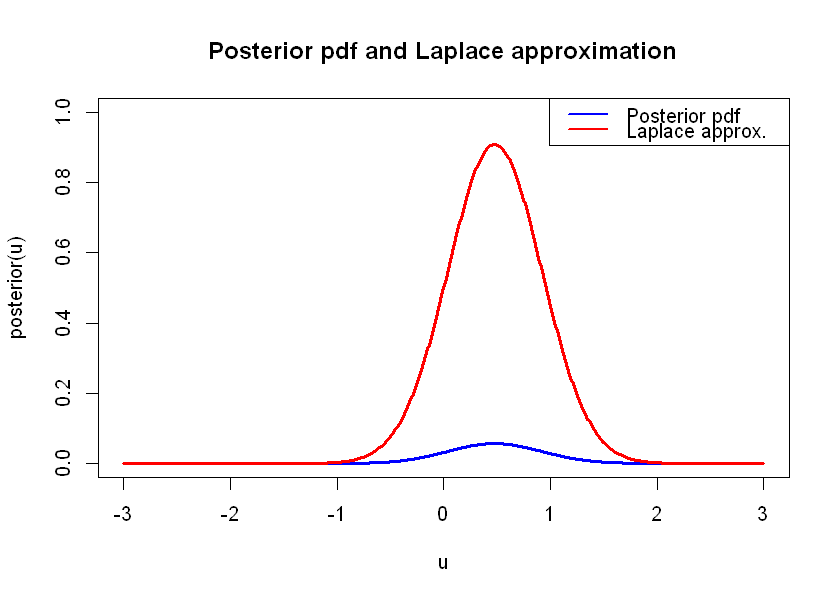

In [2]:
u<-seq(-3,3,0.01)
plot(u,posterior(u),"l",lwd=2.5,col="blue",main="Posterior pdf and Laplace approximation",ylim=c(-0,1))
lines(u,dnorm(u,mean=approx.mean,sd=approx.sd),col="red",lwd=2.5)
legend("topright",legend=c("Posterior pdf","Laplace approx."),lwd=2.2,col=c("blue","red"))


We can normalize the function just with the purpose of both functions being in the same scale:

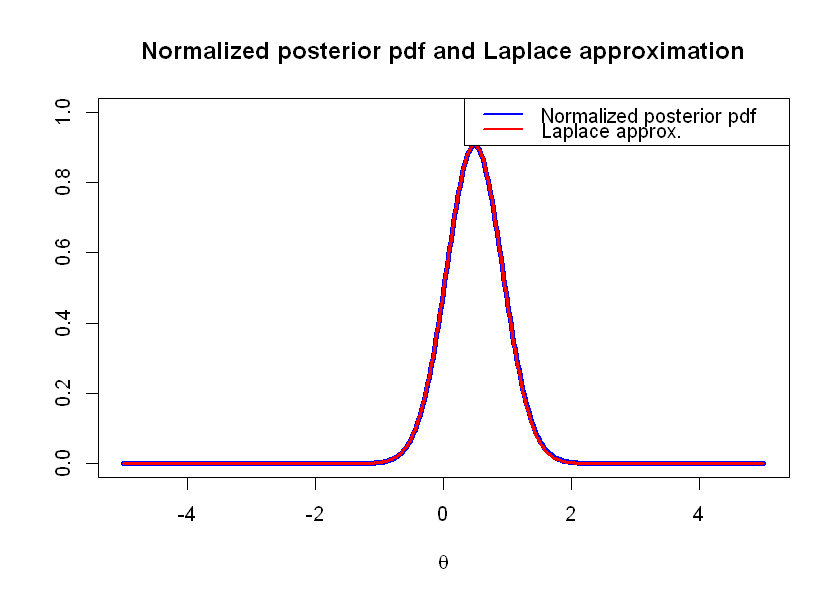

In [3]:
Z<-integrate(posterior,-5,5)$value
h<-function(theta){posterior(theta)/Z}
u<-seq(-5,5,length=500)
plot(u,h(u),"l",lwd=4.5,col="blue",main="Normalized posterior pdf and Laplace approximation",ylab="",xlab=expression(theta), ylim=c(0,1))
lines(u,dnorm(u,mean=approx.mean,sd=approx.sd),col="red",lwd=2.5)
legend("topright",legend=c("Normalized posterior pdf","Laplace approx."),lwd=2.2,col=c("blue","red"))

We compute below the probability of the coin toss heads.

In [4]:
prob.heads <- 1-pnorm(0,approx.mean, approx.sd)
prob.heads

[1] 0.8618668

Now, we can conclude that the probability of toss the coin is biased toward heads.

**b) Using the prior density as a proposal density, design a rejection algorithm for sampling from the posterior distribution. Using simulated draws from your algorithm, approximate the probability that the coin is biased toward heads.**

In Rejection sampling, we are given the target function which is the posterior $g(\theta | y)$ and the proposal density $p(\theta)$ which is the prior for $\theta \sim N(0, 0.25)$. Thus, we need firstly find the constant $M$ such that $g(\theta | y) \leq M p(\theta) $.


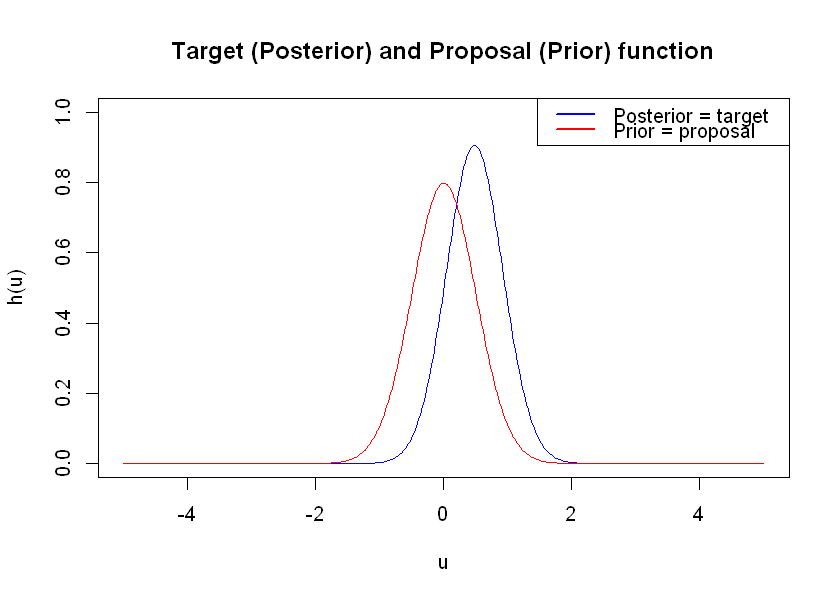

In [5]:
plot(u, h(u), type = "l", col = "blue", main="Target (Posterior) and Proposal (Prior) function", ylim = c(0,1))
lines(u, prior(u), col = "red")
legend("topright",legend=c("Posterior = target","Prior = proposal"),lwd=2.2,col=c("blue","red"))

In [6]:
find.M <- function(theta){posterior(theta)/prior(theta)}
u.M <- seq(-0.5, 1.5, length = 1000)
M <- max(find.M(u.M))
M #Print the M value

[1] 0.4578219

The rejection algorithm consists in the following steps: 

+ Generate a pair of random numbers $(u,v)$ 
+ $u$ from the proposal density, which is prior p($\theta$) with $\theta \sim N(0, 0.25)$.
+ $v$ from a Unif(0,1)
+ If $v\leq \frac{g(u)}{M·p(u)}$, then keep $u$ in the list. Otherwise throw it away.

Now, we implement R code of the above algorithm.

In [9]:
N <- 100000
theta_sample <- rnorm(N, mean, sd)
unif_sample <- runif(N)
accept <- unif_sample <= posterior(theta_sample)/(M*prior(theta_sample))
acceptance_rate <- sum(accept)/N
acceptance_rate

[1] 0.13708

Further, we show the accepted samples in a histogram which is below.

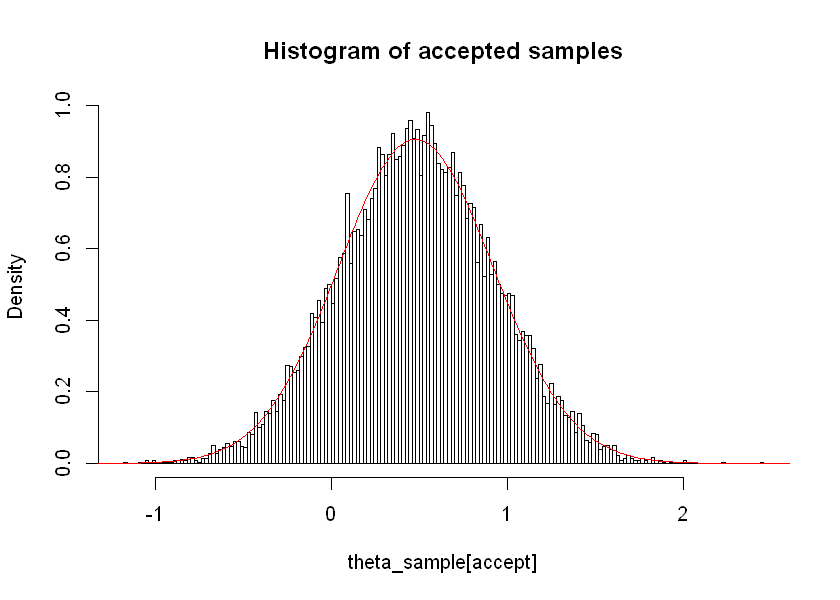

In [10]:
library(MASS)
hist(theta_sample[accept], main="Histogram of accepted samples",nclass=200, freq=FALSE)
lines(u,h(u), col="red")

Using rejection sampling, the probability for $\theta$ being larger than zero is below, which is the probability that the coin is biased toward heads.

In [11]:
prob.heads.rejection <- sum(theta_sample[accept] >= 0)/length(theta_sample[accept])
round(prob.heads.rejection, 3)

[1] 0.863

**c) Using the prior density as a proposal density, simulate values from the posterior distribution using the SIR algorithm. Approximate the probability that the coin is biased toward heads.**

In order to be able to implement the SIR algorithm, we need to define the weight function which is $$w(\theta)\equiv \frac{g(\theta|y)}{p(\theta)}$$

The SIR procedure consists in the following:
+ Start as in importance sampling:choose a proposal pdf which is prior density $\theta \sim N(0, 0.25)$, generate an $n$-sample $(\theta_1,...,\theta_n)$ from it, and the corresponding weights: $w_i=w(\theta_i)$, $1\leq i\leq n$.
+ Convert weights to probabilities: $$p_i=\frac{w_i}{\sum_{j}^{n}w_j},\quad 1\leq i\leq n$$
+ Generate a new $n$-sample (resample) from the $n$ values $(\theta_1,...,\theta_n)$ with probabilities $(p_1,...,p_n)$.

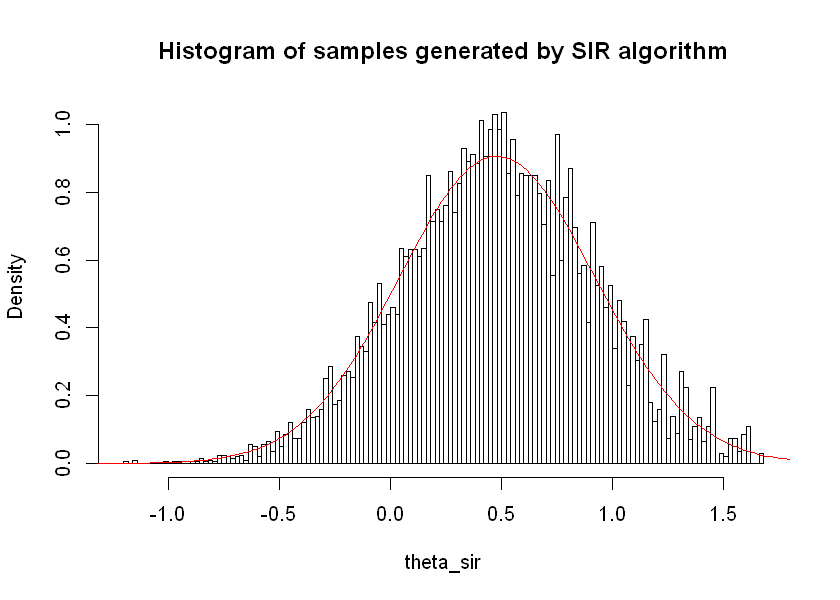

In [40]:
#Sampling
N <- 10000 
prop_sample <- rnorm(N, mean , sd) #Generate N samples following the prior density which is a Gaussian N(0,0.25)

#Calculate the sum of weights
sum.weights <- sum(posterior(prop_sample)/prior(prop_sample))

#Convert weights to probabilites
probabilities <- posterior(prop_sample)/(prior(prop_sample)*sum.weights )

#Resampling
indices <- sample(1:N, size = N, prob = probabilities, replace = TRUE)
theta_sir <- prop_sample[indices]

hist(theta_sir, main="Histogram of samples generated by SIR algorithm", nclass=200, freq=FALSE)
lines(u,h(u), col="red")


We now calculate the the probability that the coin is biased toward heads.

In [41]:
prob.heads.sir <- sum(theta_sir >= 0)/length(theta_sir)
prob.heads.sir

[1] 0.8658

# Exercise 2

**The object of this exercise is to build Metropolis-Hastings algorithm with target pdf
$$ g(\theta | y) \propto 0.8 e^{-\frac{1}{2}\theta^{2}} +0.2 e^{-\frac{1}{2}\frac{(\theta-3)^{2}}{2^{2}}} $$
a mixture of a N(0,1) and a N(3,4). **

### Part 1

**Previous work: g is written as a non-normalized pdf, since that is all we need for MH. However, the normalization constant is known $\frac{1}{\sqrt{2\pi}}$. Furthermore, we know how to simulate a mixture.
Then, plot this pdf, generate a sequence of (independent) random numbers $\sim$ g, comparing the
histogram with the pdf. Find the sample size needed to obtain a good (or, at least, acceptable)
proximity to the target pdf.**


#### Solution

First we do is generate, with $\texttt{rmultinom}$ a sequence of random number vectors according to the probabilities introduced, which are the weights of the correponding Normals.After that, we multiply each of the components of the random vector by a sequence of  random numbers corresponding to the original distribution. For example, the sequence of random numbers with probability 0.8 multiplies the random sequence of the normal distribution N(0,1). Finally, an histogram of the result is plotted as well as the theoretical function to see the goodness of the fit.

From the histogram it seems that a sequence of 5000 numbers is adequate to produce a good fit, nevertheless a bigger number would produce a more adjusted fit. 

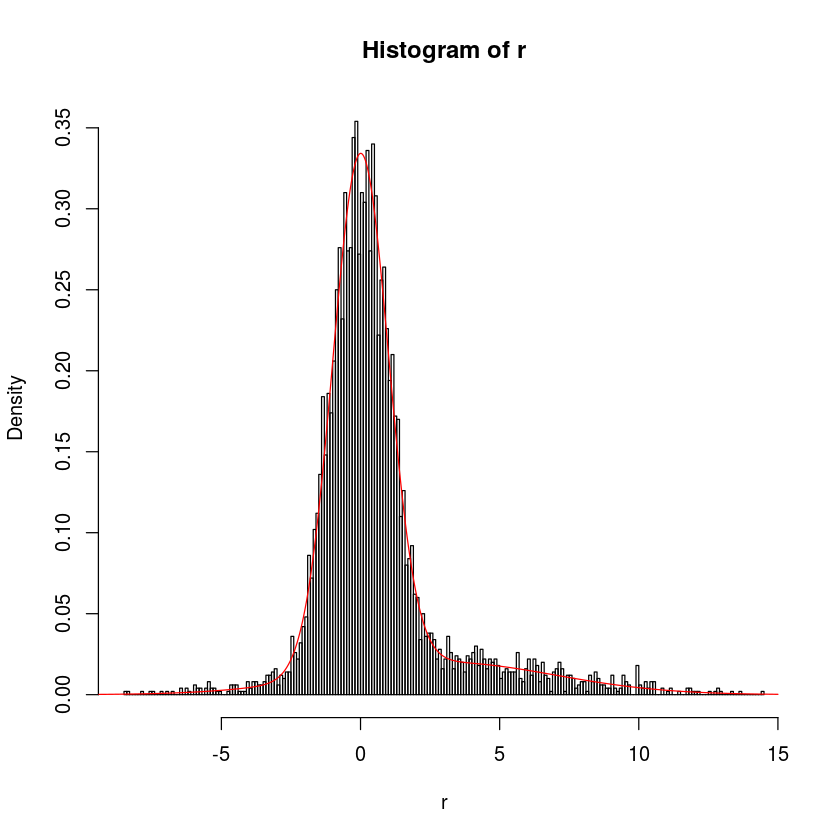

In [31]:
library('extraDistr')
n=5000
t<-seq(-10,15,0.01)
p<-rmultinom(n, 1,c(0.8,0.2))
r<-rnorm(n,0,1)*p[1,] + rnorm(n,3,4)*p[2,]
hist(r, freq=FALSE,nclass=200)
lines(t,(dnorm(t,0,1)*0.8+ dnorm(t,3,4)*0.2), col='red')

### Part 2

**Write a Metropolis-Hastings code with the proposed kernel:
$$ k(\theta^{'}|\theta)  = e^{-\frac{1}{2}(\theta^{'}-\theta)^{2})} $$
The probability of acceptance:
$$ min\left\{1, \frac{h_{x}(\theta^{'}k(\theta |\theta^{'})}{h_{x}(\theta)k(\theta^{'}|\theta)}\right\} = min\left\{1,\frac{h_{x}(\theta^{'})}{h_{x}(\theta)}\right\} $$  
The symmetry of the candidate generation implies this M-H algorithm reduces to the simple
Metropolis algorithm. Use $\theta = 2$ as the start value in the trajectory. Test the algorithm with
several values of chain length and burn-in initial discarded segment.**

#### Solution

The proposed kernel is:

In [59]:
sd.proposal.1<-1
proposal.1<-function(old.theta){
    t<-rnorm(1,mean=old.theta, sd=sd.proposal.1)
    return(t)
    }

which corresponds to a $N(\theta,1)$

The function for the posterior distribution is:

In [60]:
posterior <- function(theta){
    return (dnorm(theta,0,1)*0.8+ dnorm(theta,3,2)*0.2)
    }

And then the Metropolis algorithm which goes as follows:

+ Initiate the chain with a starting value
+ With the proposed kernel generate a jump in the $\theta$
+ Evaluate this new $\theta$ with the posterior function
+ If a uniform random number between [0,1] is smaller than
    $min\left\{1,\frac{h_{x}(\theta^{'})}{h_{x}(\theta)}\right\} $
    then the change is accepted if not the new $\theta$ is not accepted.
+ Process repeated until number of iterations reached


In [61]:
run.metropolis<-function(startvalue, iterations){
    epsilon<-1.0e-8
    chain<-rep(0,iterations+1)
    chain[1]<-startvalue
    for (i in 1:iterations){
        candidate<-proposal(chain[i])
        pp<-posterior(chain[i])
        if(pp<epsilon)    # avoid division by 0
            prob<-1
        else
            prob<-min(1,posterior(candidate)/pp)
        if(runif(1)<prob)
            chain[i+1]<-candidate
        else
            chain[i+1]<-chain[i]
        }
     return(chain)
    }
# 

And finally we run the M-H algorithm for a Chain Length of 15000 steps, a burn in of 4000 steps and a initial value of $\theta = 2$

In [62]:
proposal<-proposal.1
Chain.Length<-15000
startvalue<-2 #initial theta value
chain<-run.metropolis(startvalue,Chain.Length)
burnIn<-4000
chain1<-chain[(burnIn+1):length(chain)]

Then, once the algorithm has been ran, the traceplot and ACF of the resulting trajectories are plotted.

As can be seen the ACF plot shows a exponentially decaying correlation that has a strong endurance, little beyond 40 steps. This means that near values of the chain are strongly correlated as it is logical due to the kernel (which takes into account the last step to generate the subsequent step in the $\theta's$ space). As also seen, although the trajectory usually deviates itself from the mode it returns in the first subsequent steps, oscillating always around this value.

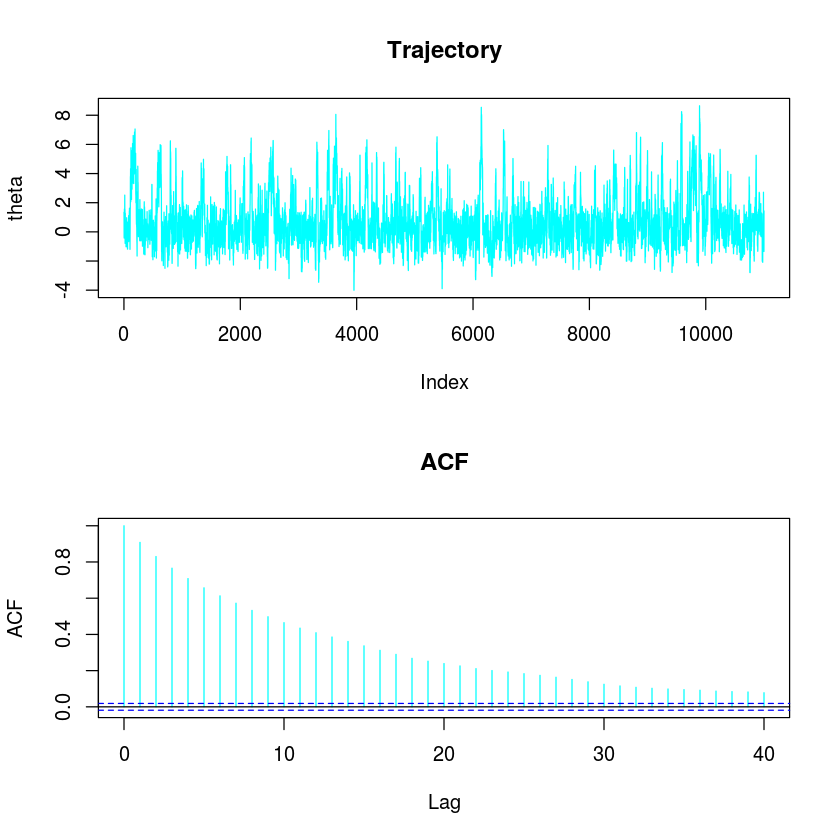

In [63]:
old.par<-par(mfrow=c(2,1))
plot(chain1,type="l",col="cyan",ylab="theta",main="Trajectory")
acf(chain1,col="cyan",main="ACF")
par(old.par)

Nextly, we plot an histogram with the result of the M-H run all along with the theoretical plot of the posterior. As can be seen, 15000 steps and 4000 dedicated to burn in are good values (with $\theta=2$ as starting value)

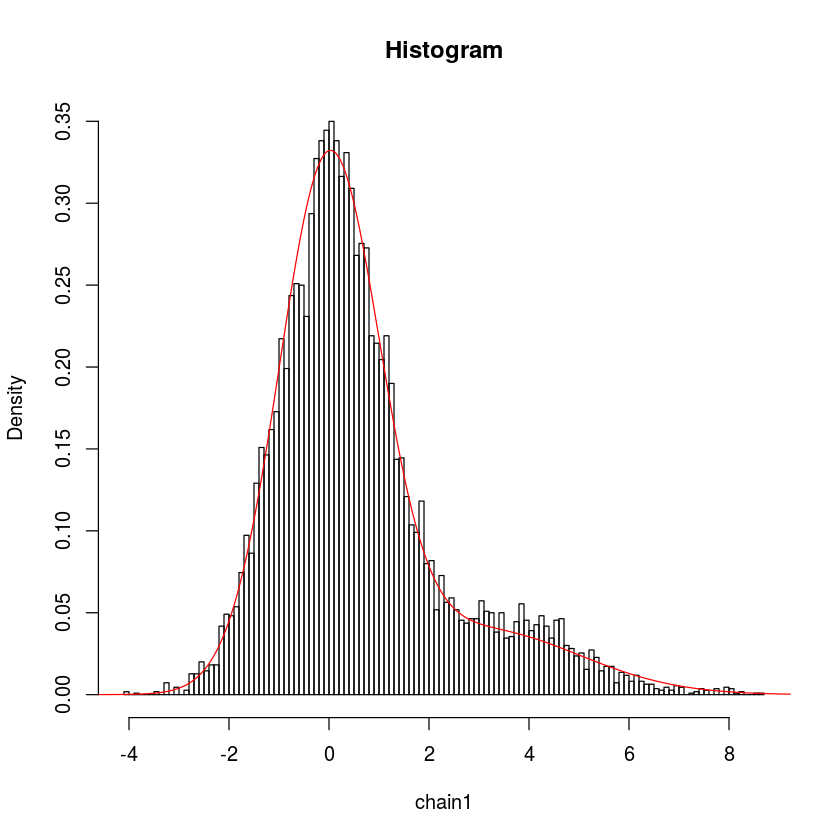

In [64]:
t <- seq(-15,15,length.out = 1000)
hist(chain1,main="Histogram", nclass=100, freq=FALSE)
lines(t,(dnorm(t,0,1)*0.8+ dnorm(t,3,2)*0.2), col='red')

As a final point we are going to try to run th M-H algorithm with different pars of values of (Chain length, burn in steps), just to see how it does affect the computation of the final posterior. Now with (7500,2000)

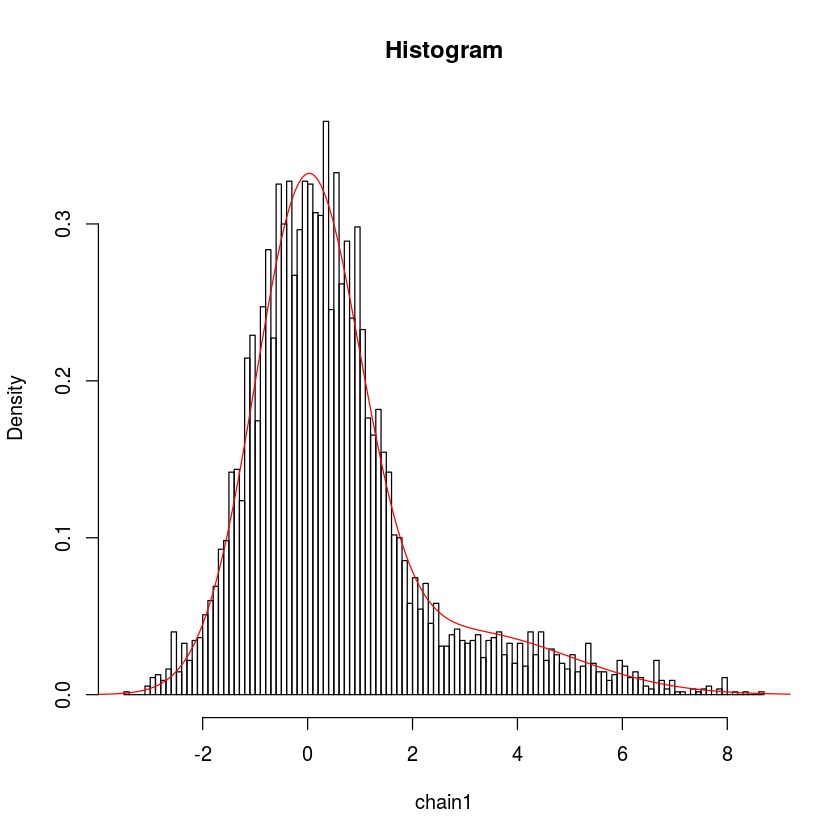

In [65]:
Chain.Length<-7500
startvalue<-2 #initial theta value
chain<-run.metropolis(startvalue,Chain.Length)
burnIn<-2000
chain1<-chain[(burnIn+1):length(chain)]
hist(chain1,main="Histogram", nclass=100, freq=FALSE)
lines(t,(dnorm(t,0,1)*0.8+ dnorm(t,3,2)*0.2), col='red')

As seen, the final distribution generated loses definition as the chain length and the burn in are reduced.

Now with (3750,1000):

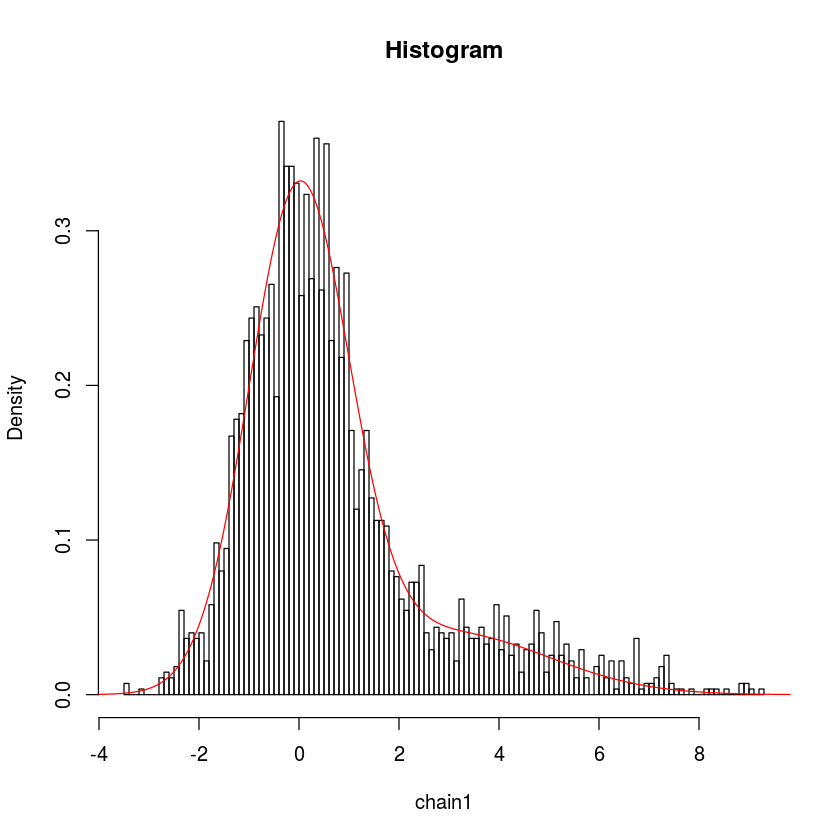

In [66]:
Chain.Length<-3750
startvalue<-2 #initial theta value
chain<-run.metropolis(startvalue,Chain.Length)
burnIn<-1000
chain1<-chain[(burnIn+1):length(chain)]
hist(chain1,main="Histogram", nclass=100, freq=FALSE)
lines(t,(dnorm(t,0,1)*0.8+ dnorm(t,3,2)*0.2), col='red')

Obviously, if the length of the chain is augmented and the burn in does not correspond to a great portion of it, the algorithm can explore the space of the $\theta's$ with more detail hence producing a more accurate final posterior distribution. Ths can be seen next (using (30000,8000)):

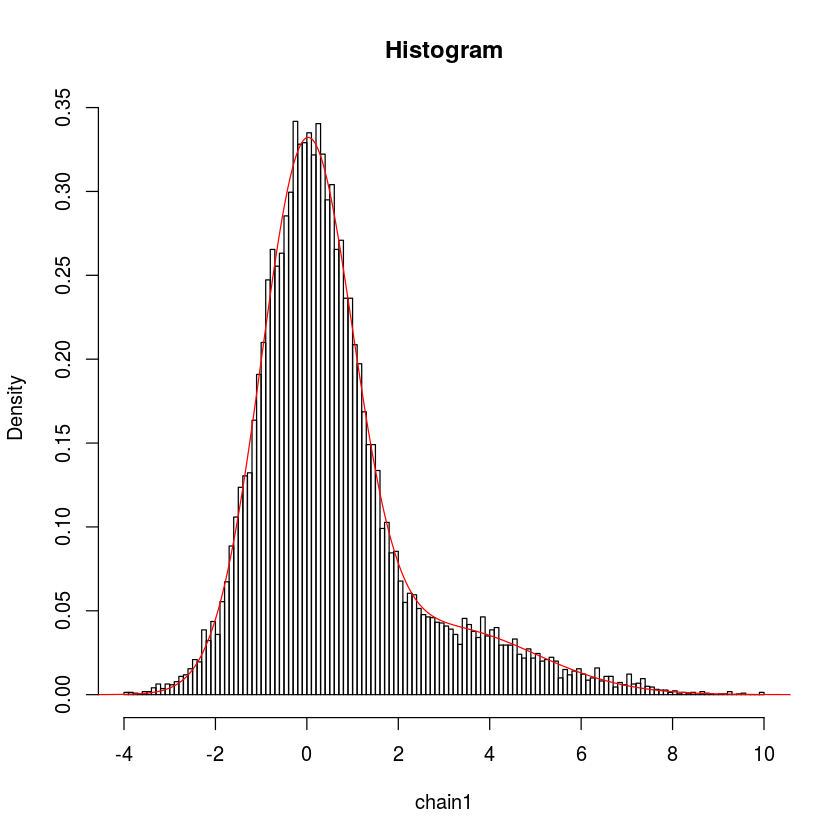

In [67]:
Chain.Length<-30000
startvalue<-2 #initial theta value
chain<-run.metropolis(startvalue,Chain.Length)
burnIn<-8000
chain1<-chain[(burnIn+1):length(chain)]
hist(chain1,main="Histogram", nclass=100, freq=FALSE)
lines(t,(dnorm(t,0,1)*0.8+ dnorm(t,3,2)*0.2), col='red')

### Part 3

**Write a Metropolis-Hastings code with the candidate proposal kernel:
$$k(\theta^{'}|\theta) = q(\theta^{'}) = e^{-\frac{1}{2}(\frac{\theta^{'}}{3})^{2}}$$
a $N(0, 3^{2})$ pdf. M-H algorithm using such a candidate proposal kernel is called independent candi-
date M-H algorithm. With it, the probability of acceptance is:
$$ min\left\{1, \frac{h_{x}(\theta^{'}k(\theta |\theta^{'})}{h_{x}(\theta)k(\theta^{'}|\theta)}\right\} = min\left\{1,\frac{h_{x}(\theta^{'})q(\theta)}{h_{x}(\theta)q(\theta^{'})}\right\} $$  
Use $\theta = 0.4448$ as the start value in the trajectory. Test the algorithm with several values of
chain length and burn-in initial discarded segment. Discuss traceplot, ACF and histogram of the
chains tested.**


#### Solution

The new kernel is (both random generation and density value):

In [75]:
proposalk<-function(){
    t<-rnorm(1,mean=0, sd=3)
    return(t)
    }
proposalkd<-function(theta){
    t<-dnorm(theta,mean=0, sd=3)
    return(t)
    }


New algorithm regarding independent kernel:

In [76]:
run.metropolis.indep<-function(startvalue, iterations){
    epsilon<-1.0e-8
    chain<-rep(0,iterations+1)
    chain[1]<-startvalue
    for (i in 1:iterations){
        candidate<-proposal()
        pp<-posterior(chain[i])
        if(pp<epsilon)    # avoid division by 0
            prob<-1
        else
            prob<-min(1,(posterior(candidate)*proposald(chain[i]))/(pp*proposald(candidate)))
        if(runif(1)<prob){
            chain[i+1]<-candidate}
        else{
            chain[i+1]<-chain[i]}
        }
     return(chain)
    }
# 

The important change are that now the kernel does not depend on the las steps and that the probability of jump towards which is compared the uniform random number has changed, now is:

$$min\left\{1,\frac{h_{x}(\theta^{'})q(\theta)}{h_{x}(\theta)q(\theta^{'})}\right\}$$

all the changes can be seen in the script.

As can be expected, due to the independence of the kernel on the previous step we anticipate that the ACF will have a low endurance and only will last for the first previous steps.

Run the algorithm with the new kernel, algorithm and starting value:

In [77]:
proposal<-proposalk
proposald <-  proposalkd
Chain.Length<-15000
startvalue<-0.4448 #initial theta value
chain<-run.metropolis.indep(startvalue,Chain.Length)
burnIn<-4000
chain1<-chain[(burnIn+1):length(chain)]

Then the traceplot and ACF of the resulting trajectory are obtained:

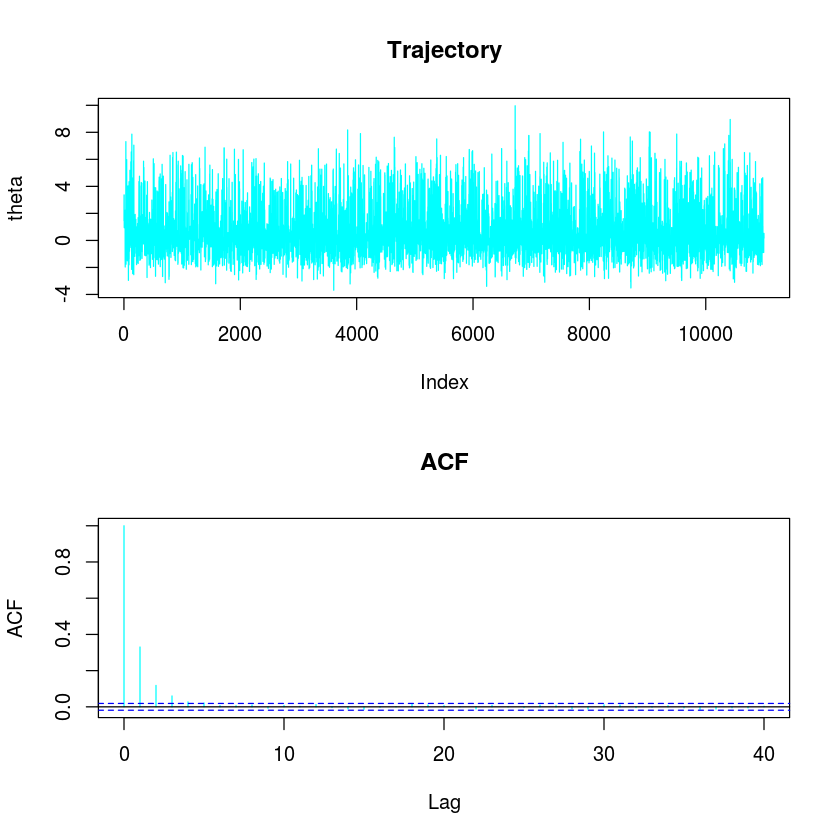

In [78]:
old.par<-par(mfrow=c(2,1))
plot(chain1,type="l",col="cyan",ylab="theta",main="Trajectory")
acf(chain1,col="cyan",main="ACF")
par(old.par)

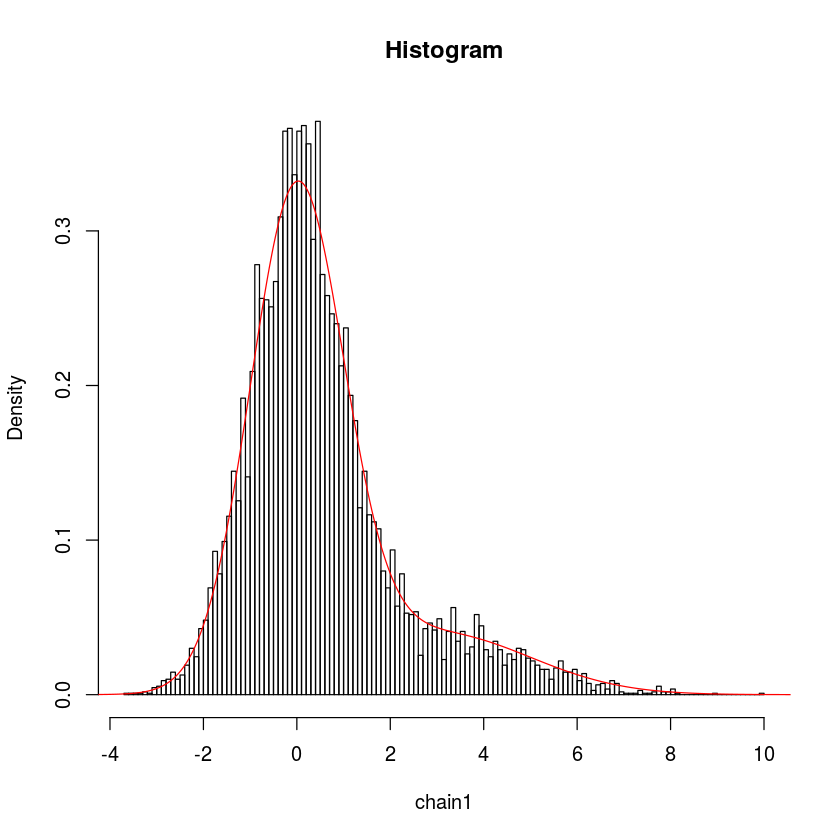

In [79]:
t <- seq(-15,15,length.out = 1000)
hist(chain1,main="Histogram", nclass=100, freq=FALSE)
lines(t,(dnorm(t,0,1)*0.8+ dnorm(t,3,2)*0.2), col='red')

As can be seen and as we expected the ACF shows that there is low correlation between the steps: it lasts a few steps only. That means that fixed a step in the trajectory, beyond approximately the 4 step backwards, that step is independent of all steps beyond this number. Also to comment important to comment about the traceplot is that, although when the trajectory deviates from the mode of $\theta$ it returns to this value, there is a bias corresponding to what direction the trajectory deviates to. As seen it usually deviates more towards positive values due to the characteristics of the distribution (more weight on positive values).

Nextly we try to run the M-H with different numbers of chain length and burn in steps. Now (7500,2000

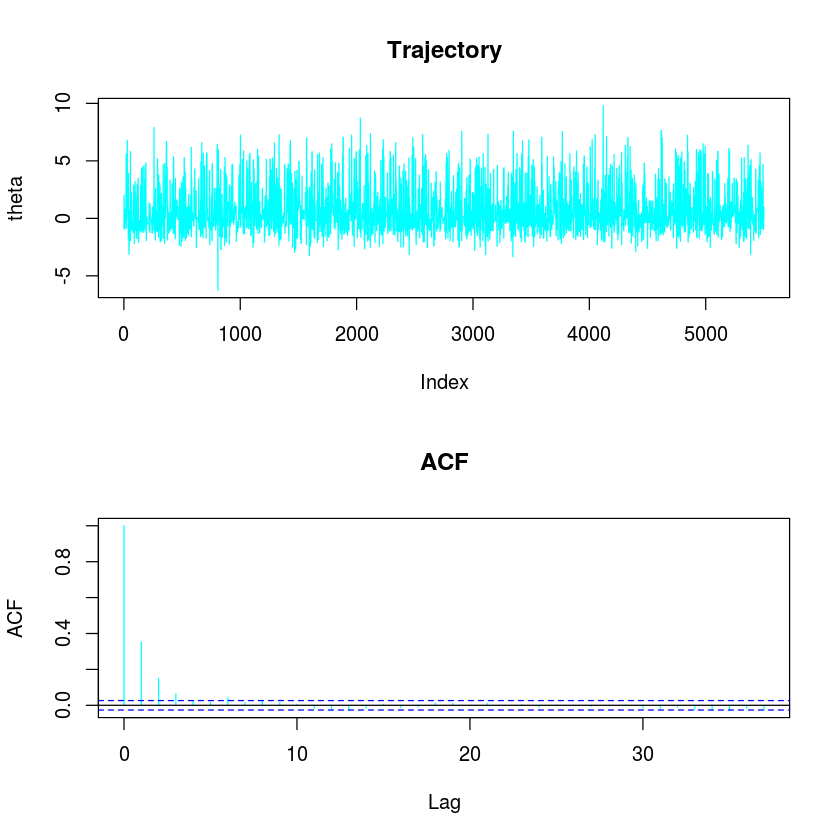

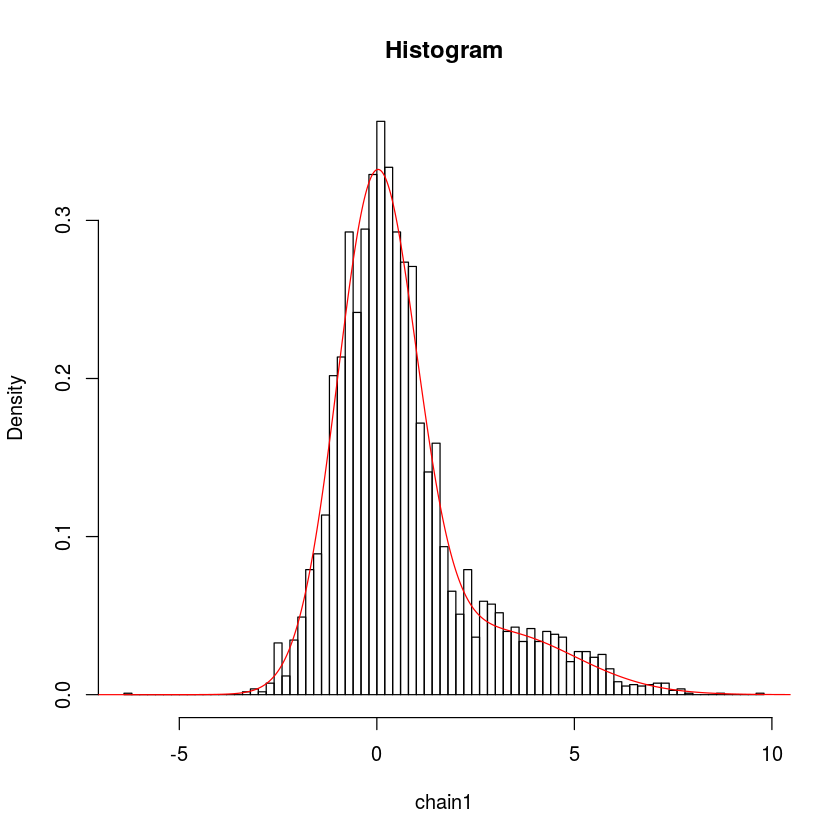

In [82]:
Chain.Length<-7500
startvalue<-2 #initial th.eta value
chain<-run.metropolis.indep(startvalue,Chain.Length)
burnIn<-2000
chain1<-chain[(burnIn+1):length(chain)]
old.par<-par(mfrow=c(2,1))
plot(chain1,type="l",col="cyan",ylab="theta",main="Trajectory")
acf(chain1,col="cyan",main="ACF")
par(old.par)
hist(chain1,main="Histogram", nclass=100, freq=FALSE)
lines(t,(dnorm(t,0,1)*0.8+ dnorm(t,3,2)*0.2), col='red')

Now (3750,1000)

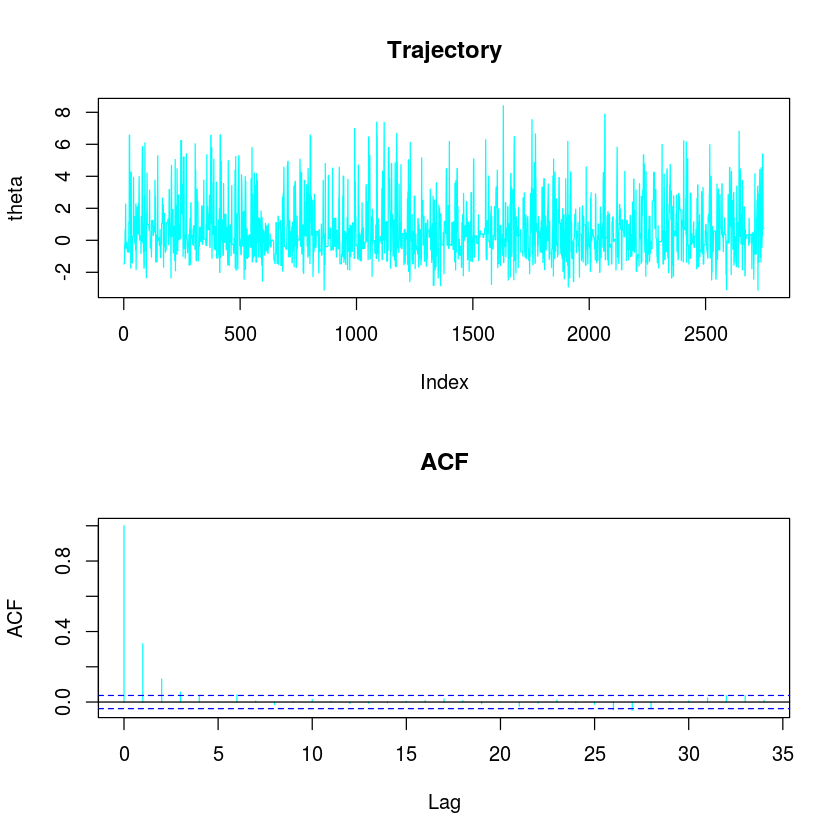

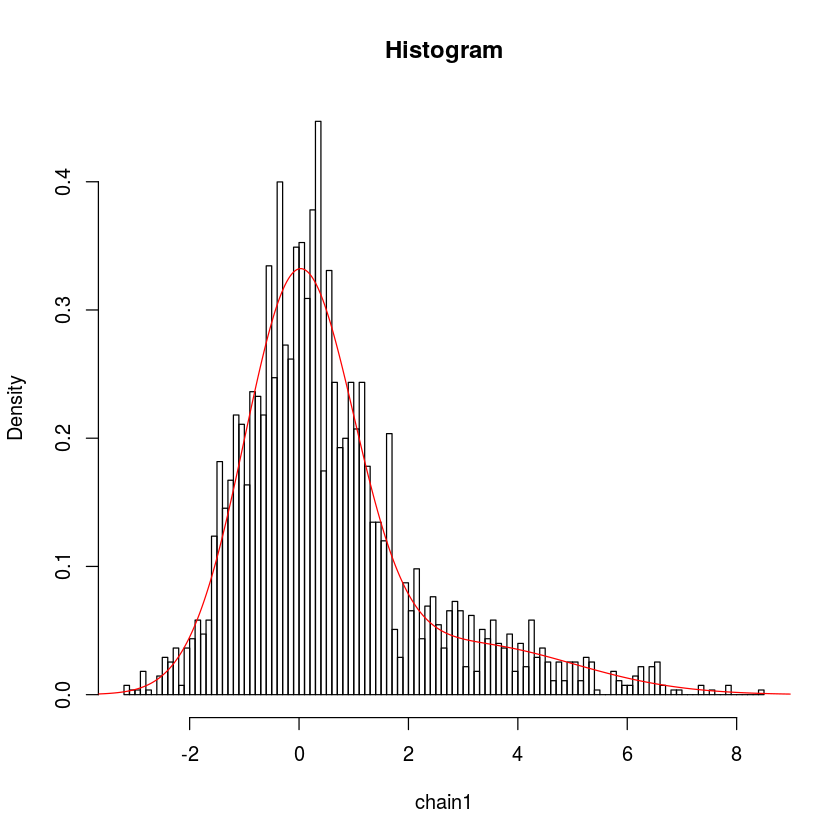

In [83]:
Chain.Length<-3750
startvalue<-2 #initial th.eta value
chain<-run.metropolis.indep(startvalue,Chain.Length)
burnIn<-1000
chain1<-chain[(burnIn+1):length(chain)]
old.par<-par(mfrow=c(2,1))
plot(chain1,type="l",col="cyan",ylab="theta",main="Trajectory")
acf(chain1,col="cyan",main="ACF")
par(old.par)
hist(chain1,main="Histogram", nclass=100, freq=FALSE)
lines(t,(dnorm(t,0,1)*0.8+ dnorm(t,3,2)*0.2), col='red')

As happened before as greater is the chain length, and the burn in steps do not correspond to a great portion of the chain (only the necessary to entry the stationary stadium), the better is the approximation of the final distribuition. This is due to the fact that then the algorithm can explore the $\theta's$ space in more detail and hence produce a better trajectory adn final histogram. Nevertheless, as the chain length increases more computational time costs the process. Hence an equilibrium between the needed exploration of the variable space and the computational cost has to be found.

In our case (30000,8000) produce a good and not too computationally demanding result:


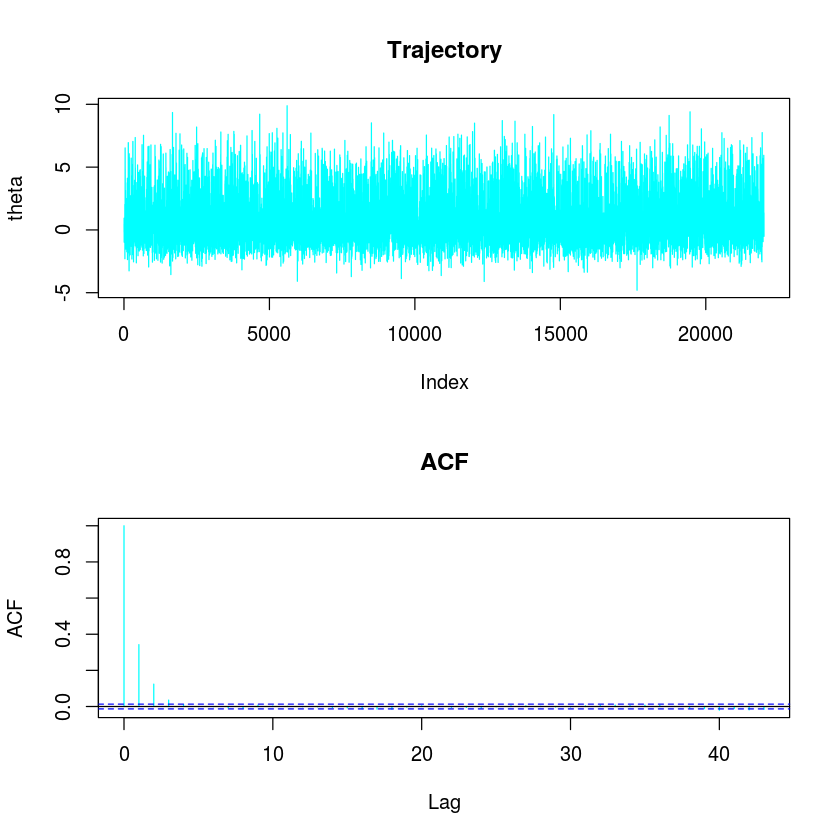

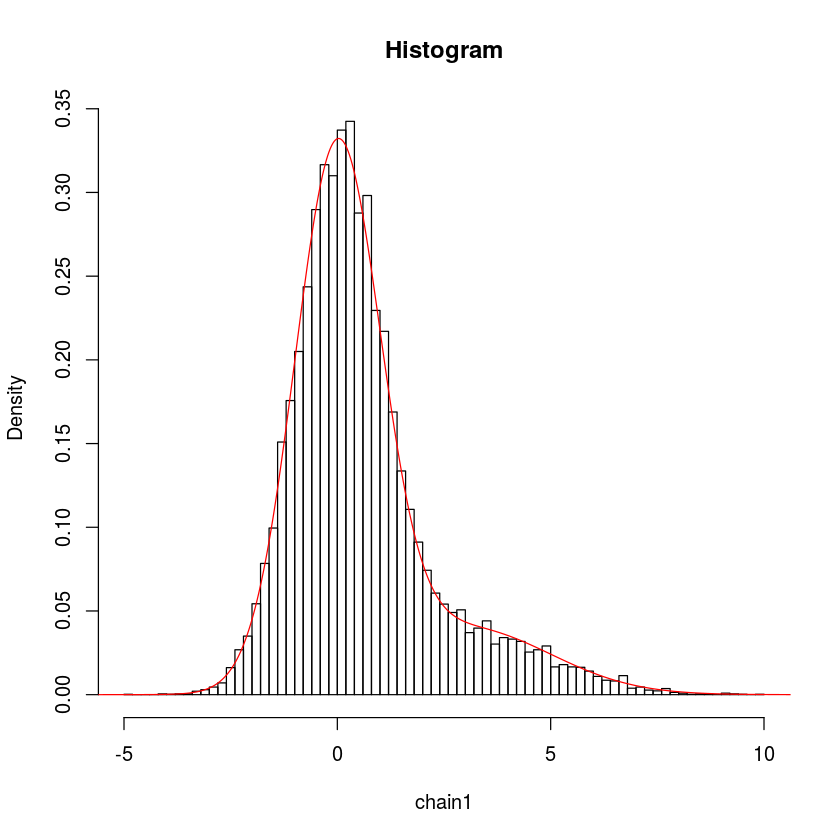

In [84]:
Chain.Length<-30000
startvalue<-2 #initial th.eta value
chain<-run.metropolis.indep(startvalue,Chain.Length)
burnIn<-8000
chain1<-chain[(burnIn+1):length(chain)]
old.par<-par(mfrow=c(2,1))
plot(chain1,type="l",col="cyan",ylab="theta",main="Trajectory")
acf(chain1,col="cyan",main="ACF")
par(old.par)
hist(chain1,main="Histogram", nclass=100, freq=FALSE)
lines(t,(dnorm(t,0,1)*0.8+ dnorm(t,3,2)*0.2), col='red')

## Exercise 3

To complete this exercise, we follow the instructions given in exercise 6.4 in the book of Robert and Casella. It states:

Exercise 6.4

Consider the target as the $Gamma(\alpha, \beta)$ distribution and the candidate
as the gamma $G([\alpha], b)$ distribution (where $[\alpha]$ denotes the integer part of $\alpha$).

a. Derive the corresponding Accept/Reject method and show that, when $\beta = 1$,
the optimal choice of $b$ is $b = [\alpha]/\alpha$.

b. Generate 5000 $Gamma(4, 4/4.85)$ random variables to derive a $Gamma(4.85, 1)$ sample
(note that you will get less than 5000 random variables).

c. Use the same sample in the corresponding Metropolis-Hastings algorithm to
generate 5000 $Gamma(4.85, 1)$ random variables.

d. Compare the algorithms using (i) their acceptance rates and (ii) the estimates
of the mean and variance of the $G(4.85, 1)$ along with their errors. (Hint:
Examine the correlation in both samples.)

### Define parameters and functions

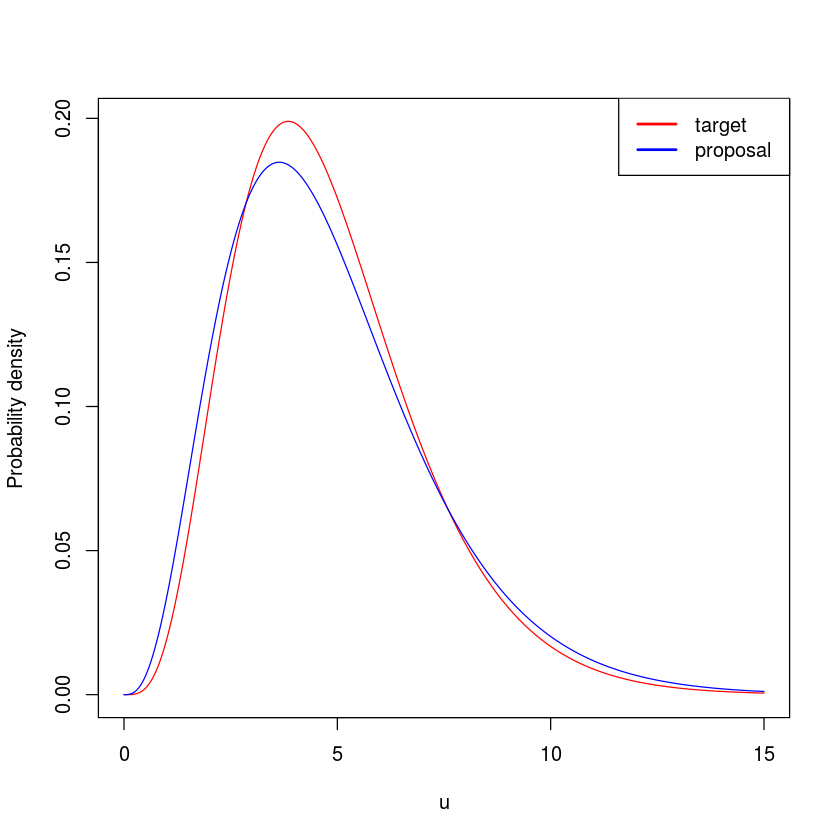

In [30]:
### Target and candidate densities
target_pdf <- function(x){dgamma(x,alpha,beta)}
candidate_pdf <- function(x){dgamma(x,a,b)}

### PARAMS
N = 5000
alpha <- 4.85
beta <- 1
a <- floor(alpha)
b <- a/alpha
u <- seq(0,15,length=10000)

plot(u, target_pdf(u), type = "l", col = "red", ylab = "Probability density")
lines(u, candidate_pdf(u), type = "l", col = "blue")
legend("topright",legend=c("target","proposal"),lwd=2.2,col=c("red","blue"))

#### a. Derive the corresponding Accept/Reject method and show that, when $\beta = 1$, the optimal choice of $b$ is $b = [\alpha]/\alpha = a/\alpha$.

The target density $g(x)$ and the candidate density $h(x)$ are, respectively,

$$
g(x) = G(\alpha, 1) = \frac{1}{\Gamma(\alpha)} x^{\alpha - 1} e^{-x}
$$
and 
$$
h(x) = G(a, b) = \frac{b^a}{\Gamma(a)} x^{a - 1} e^{-bx}
$$
Our goal is to find the smallest $M$ that fulfills
$$
\frac{g(x)}{h(x)} \leq M~\forall~x
$$

to increase the acceptance rate $1/M$ and therefore the efficiency of the algorithm. Let us write the fraction of target over candidate

$$
f(x) = \frac{g(x)}{h(x)} = \frac{\Gamma(a)}{\Gamma(\alpha)b^{a}} x^{\alpha - a} e^{(b-1)x} 
$$

To find the maximum of the function $f(x)$ we compute the derivative with respect to $x$ and set it to zero

$$
\frac{d}{dx} f(x)= \frac{\Gamma(a)}{\Gamma(\alpha)b^{a}} \left((\alpha-a)x^{\alpha-a-1}e^{(b-1)x} + x^{\alpha-a}(b-1)e^{(b-1)x} \right) = 0 \\
\iff (\alpha - a)x^{\alpha-a-1} + x^{\alpha-a}(b-1) = 0 \\
\iff x = \frac{\alpha - a}{1 - b}
$$

We can plug this into $f(x)$ and compute the derivative with respect to b and set it to zero (consider $\alpha \ne a$)

$$
\frac{d}{db} f(b) = const \cdot \left((-a) b^{-a-1} (1 - b)^{a-\alpha} - b^{-a} (a - \alpha) (1 - b)^{a - \alpha - 1} \right) = 0 \\
\iff (-a) b^{-1} = (a - \alpha)(1 - b)^{-1} \\
\iff b = \frac{a}{\alpha},
$$
which is the desired result. 

To derive the entire accept-reject algorithm we also derive a way of sampling from the candidate function with the inverse cdf method, although we could sample from the candidate directly. In particular,
sampling from $Gamma(a,b)$ ($a = floor(\alpha)$, $b = a/\alpha$) is equivalent to sample from the sum of a i.i.d random variables distributed as $Exp(\beta)$ ($\beta = 1$). The inverse cdf of

$$
p(x) = Exp(\beta) = \Bigg\{\begin{aligned} \beta e^{-\beta x},~ x \geq 0 \\ 0,~ otherwise \end{aligned}
$$
is
$$
P^{-1}(y) = - \frac{1}{\beta} log(1-y). 
$$

Let us now implement all this.

In [31]:
require(stats)
inverse_cdf <- function(n){-1/b*log(1-runif(n))}
optim_fct <- function(x){target_pdf(x)/candidate_pdf(x)}
sol <- optimize(optim_fct, interval = c(0,15), maximum = T)
M <- sol$maximum
M

[1] 4.849998

This previous value is the value for M as defined above as the maximum of target over candidate for all x. 

#### b. Generate 5000 $Gamma(4, 4/4.85)$ random variables to derive a $Gamma(4.85, 1)$ sample (note that you will get less than 5000 random variables).

Next, we implement functions to generate the candidate sample and to implement the accept-reject algorithm with the provided parameters (which are defined at the beginning of the exercise).

In [33]:
candidate_generation_inverse_cdf <- function(N = 1){
    candidate_sample <- array(dim=c(N,a))
    for(i in 1:a){
        candidate_sample[,i] <- inverse_cdf(N)
    }

    candidate_sample <- apply(candidate_sample, 1, sum)
}

accept_reject <- function(target_pdf, candidate_pdf, rcandidate, M, N){
    sample <- rcandidate(N)
    accept <- target_pdf(sample)/(M*candidate_pdf(sample))
    u <- runif(N)
    sample[u<accept]
}

Let us run the algorithm and compare the acceptance rate to the theoretical acceptance rate

In [34]:
round(1/M,3)

[1] 0.206

In [35]:
accept <- accept_reject(target_pdf, candidate_pdf, candidate_generation_inverse_cdf, M, N)
accept_rate <- length(accept)/N
accept_rate

[1] 0.206

These two values are very close, but it varies with every execution. Choosing a larger sample size gives better agreement.

Now we compare the theoretical probability density with the obtained samples from the accept-reject method.

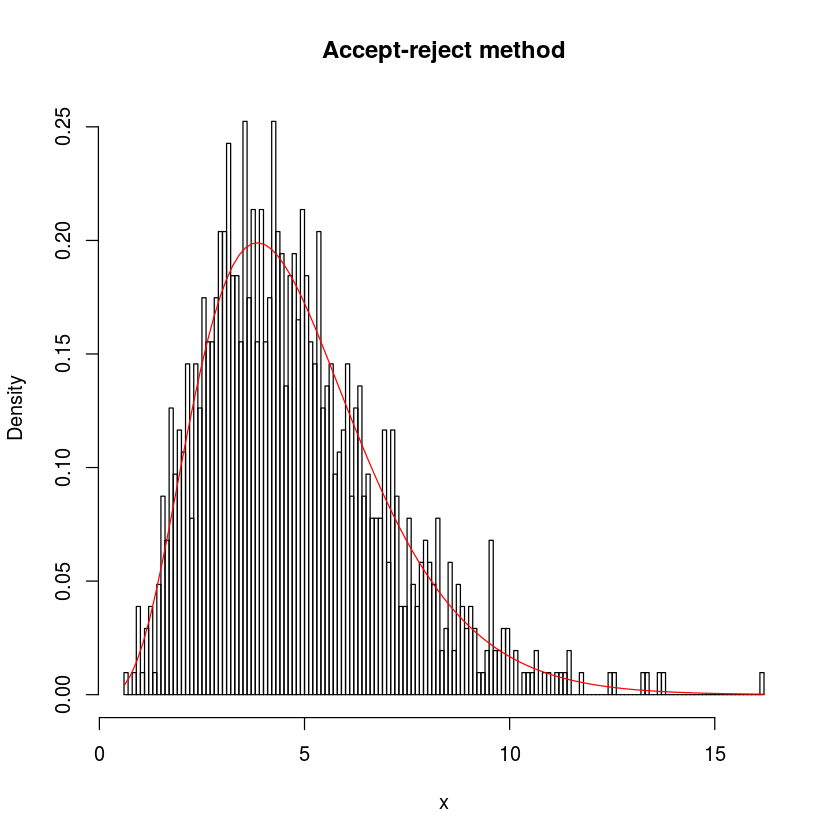

In [36]:
hist(accept, nclass=150, freq = F, main = "Accept-reject method", xlab = "x")
curve(target_pdf,, col = "red", add = T)

#### c. Use the same sample in the corresponding Metropolis-Hastings algorithm to generate 5000 $Gamma(4.85, 1)$ random variables.

In [37]:
run_metropolis_hastings <- function(g_pdf, proposal_pdf, rproposal, startvalue, iterations){
    chain<-array(dim = c(iterations+1,1))
    chain[1] <- startvalue
    
    for(i in 1:iterations){
        theta1 <- rproposal()
        
        accept_prob <- (g_pdf(theta1)*proposal_pdf(chain[i]))/(g_pdf(chain[i])*proposal_pdf(theta1))

        if(runif(1) < accept_prob){
            chain[i+1] <- theta1
        } else {
            chain[i+1] <- chain[i]
        }
    }
    
    chain
}

In [38]:
metr_samples <- run_metropolis_hastings(target_pdf, candidate_pdf, candidate_generation_inverse_cdf, a, N)

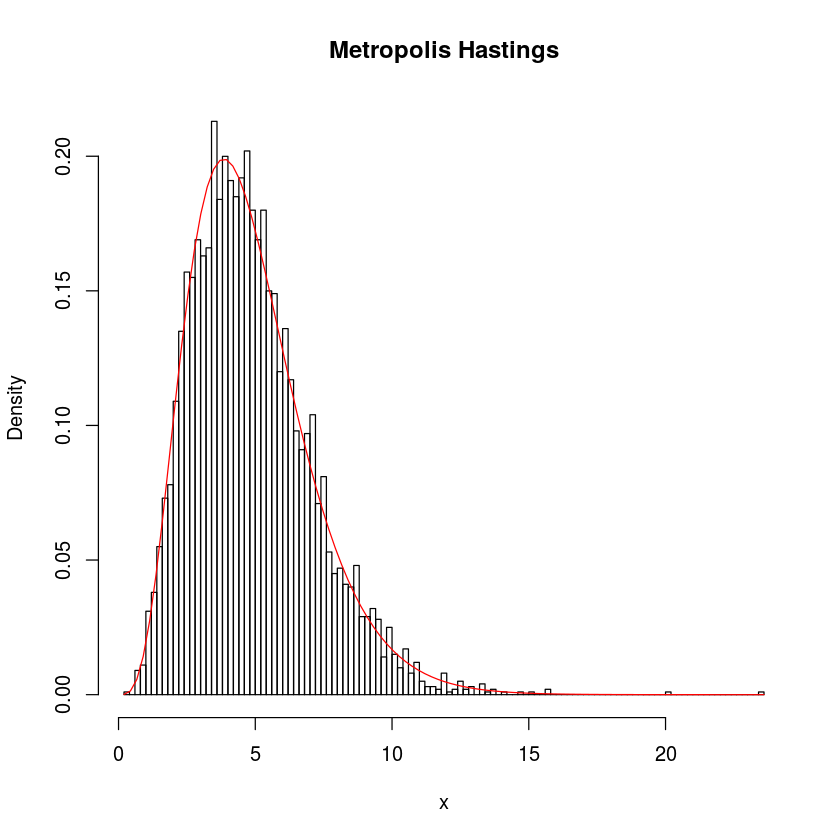

In [39]:
hist(metr_samples, nclass = 150, freq = F, main = "Metropolis Hastings", xlab = "x")
curve(target_pdf, add = T, col = "red")

For some reason the samples of the Metropolis-Hastings follow the theoretical distribution better than the samples of the Accept-Reject method. A comparison of the algorithms can shed light onto this.

#### d. Compare the algorithms using (i) their acceptance rates and (ii) the estimates of the mean and variance of the  G(4.85,1)  along with their errors. (Hint: Examine the correlation in both samples.)

#### (i)

The Metropolis-Hastings acceptance rate is

In [40]:
metr_accept_rate <- length(metr_samples[!duplicated(metr_samples)])/N
metr_accept_rate

[1] 0.9352

This acceptance rate is more than 4 times higher than the acceptance rate of the Accept-Reject method, which explains the better agreement to the theoretical curve. Note, that using a burn in interval here is not necessary, as we used an independent candidate generation.

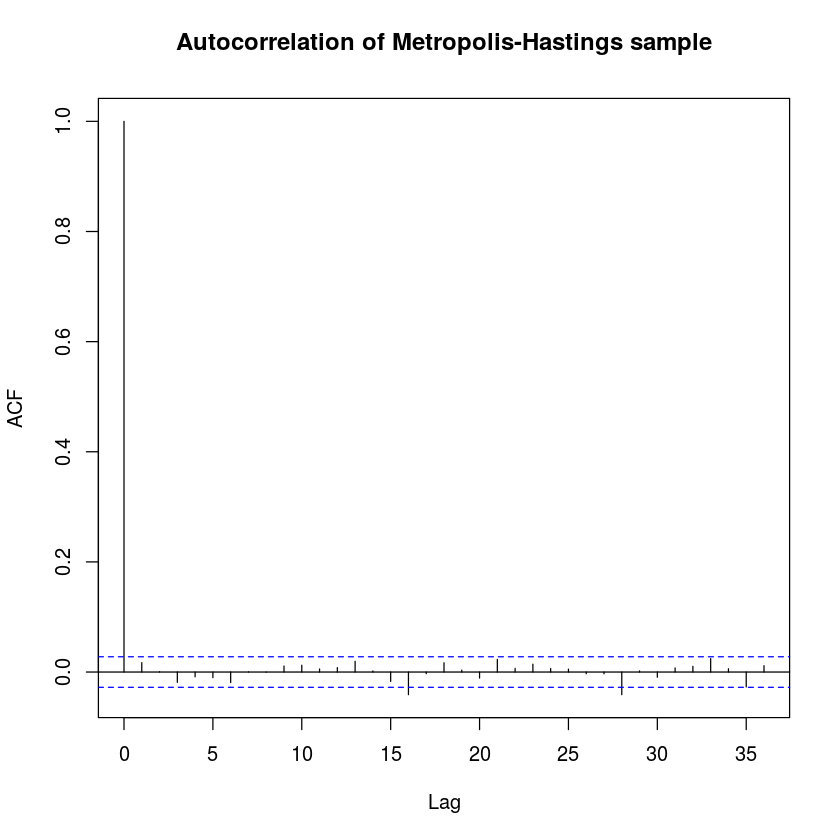

In [41]:
acf(metr_samples, main = "Autocorrelation of Metropolis-Hastings sample")

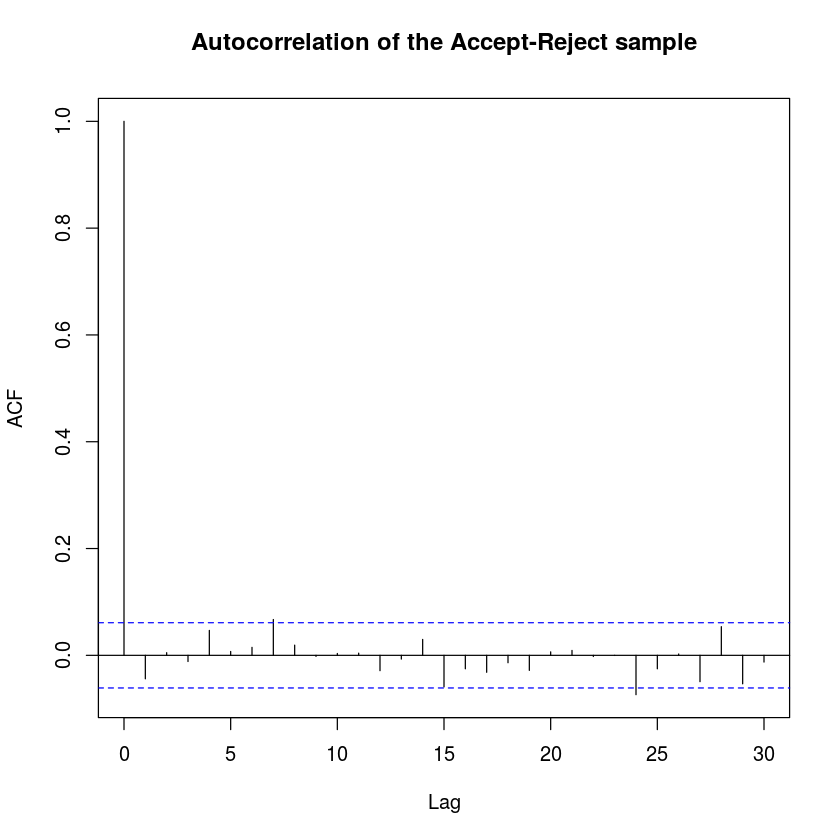

In [42]:
acf(accept, main = "Autocorrelation of the Accept-Reject sample")

As can be seen both samples have negligible autocorrelation, but the accept-reject method has even smaller correlation.

#### (ii)

The theoretical mean and variance of a $Gamma(4.85,1)$ are

$$
E[X] = \frac{\alpha}{\beta} = 4.85 \\
var[X] = \frac{\alpha}{\beta^2} = 4.85
$$

The mean and the variance of the Metropolis-Hastings sample are, respectively

In [48]:
mean(metr_samples)
var(metr_samples)

[1] 4.869189

4.801584


The mean and the variance of the Accept_reject sample are, respectively

In [47]:
mean(accept)
var(accept)

[1] 4.797771

[1] 4.925527